# Random Forest

In [2]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile

First, we load the data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
local_zip = '/content/Pickles.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(".")
zip_ref.close()

In [4]:
# Dataframe
path_df = "/content/Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "/content/Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/content/Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/content/Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/content/Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [5]:
print(features_train.shape)
print(features_test.shape)

(1275, 300)
(225, 300)


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [6]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node
* `bootstrap` = method for sampling data points (with or without replacement)

### Randomized Search Cross Validation

We first need to define the grid:

In [7]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


Then, we'll perform the Random Search:

In [8]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  7.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

We can see the best hyperparameters resulting from the Random Search:

In [9]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9701960784313726


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [10]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  5.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sampl...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  

The best hyperparameters turn out to be:

In [11]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.9675376088677751


Let's save the model in `best_rfc`:

In [12]:
best_rfc = grid_search.best_estimator_

In [13]:
best_rfc

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

We now know the best random forest model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [14]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

And get the predictions:

In [15]:
rfc_pred = best_rfc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`rfc_pred = best_rfc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [16]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
1.0


#### Test accuracy

In [17]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.9733333333333334


#### Classification report

In [18]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           1       0.94      0.99      0.96        69
           2       0.99      0.96      0.97        73
           3       0.99      0.98      0.98        83

    accuracy                           0.97       225
   macro avg       0.97      0.97      0.97       225
weighted avg       0.97      0.97      0.97       225



#### Confusion matrix

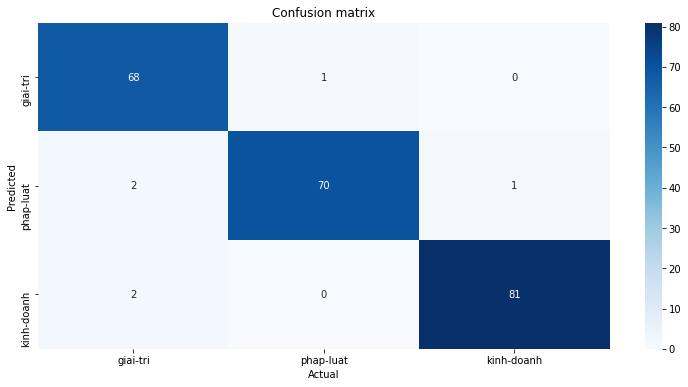

In [19]:
aux_df = df[['category', 'category_code']].drop_duplicates().sort_values('category_code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['category'].values, 
            yticklabels=aux_df['category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [20]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9644444444444444

In [21]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.9733333333333334

We'll create a dataset with a model summary to compare models:

In [22]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [24]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,1.0,0.973333


Let's save the model and this dataset:

In [25]:
with open('/content/drive/MyDrive/Mo_dels/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('/content/drive/MyDrive/Mo_dels/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)